# CADP tools queries 

## 2. SVL queries

In [23]:
import pandas as pd
import numpy as np 
from ast import literal_eval

In [24]:
file_name = "9M-5-[1-2001]-[firstpromo]-lcm.bcg"
file_path = f"../graph/bcg/{file_name}"

In [25]:
before_promo_period = "2018-09-01"
promo_period ="2018-12-01"
after_promo_period = ":2019-02-01"

In [26]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.classes_ = np.load(f'../../plots/encoders/{file_name.replace("bcg","out")}.npy')
promo_products = pd.read_csv("../../datasets/Total/promo_products.csv")
promo_products = promo_products[promo_products.ARTICLE_ID.isin(encoder.classes_)]
promo_products.ARTICLE_ID.apply(lambda x : encoder.transform([x]))
promo_products = f':{":".join(promo_products.ARTICLE_ID.astype(str).unique())}:'

In [27]:
graph_path = '../graph/bcg/9M-5-\[1-2001\]-\[a\]-lcm.bcg'

# Short term loyalty 1 
parameters = "T0=:2018-09-01 T1=:2018-12-01"
query_path = "../queries/mcl/product_st_loyalty.mcl"
def run_query(query_path,graph_path,parameters,columns = ["CUST_ID","ARTICLE_ID"],extra_cols =[],execution_time=False):
    """
    Run query using MCL and return the formated output
    Parameters
    ----
    query_path : str
    graph_path : str
    parameters : str
        ex: "T0=:2018-09-01 T1=:2018-12-01"
    columns : list of str
    extr_cols: list of str
        extra columns for queries having more return values than the default ones in columns 
    """
    !{parameters} envsubst < {query_path} > query.mcl
    data = !bcg_open {graph_path} evaluator4 query.mcl
    data = pd.DataFrame([[literal_eval(ii) for ii in i.split("$")] for i in data[2:-2]],columns=["CUST_ID","ARTICLE_ID"])
    data["query_type"] = query_path.split("/")[-1].replace(".mcl","")
    return data
def extract_user_stats(x,columns):
    user = x["CUST_ID"]
    for col in columns:
        for val in x[col]:
            res.append((user,col,val))

### Queries

In [28]:
graph_path = '../graph/bcg/9M-5-[1-2001]-[a]-lcm.bcg'
output = []

# #  Adoption  
# query_path = "../queries/mcl/adoption.mcl"
# parameters = "T0=:2018-09-01 T1=:2018-12-01"
# df = run_query(query_path,graph_path,parameters)
# output.append(df)

# Short term loyalty 1 
query_path = "../queries/mcl/product_st_loyalty.mcl"
df = run_query(query_path,graph_path,parameters)
df["query_type"]="loyalty1"
output.append(df)


# Short term loyalty 2 
parameters = "T0=:2018-12-01 T1=:2019-02-01"
df = run_query(query_path,graph_path,parameters)
df["query_type"]="loyalty2"
output.append(df)


# # Promo exclusive 
# parameters = "T0=:2018-09-01 T1=:2018-12-01 T2=:2019-02-01"
# query_path = "../queries/mcl/promo_exclusive.mcl"
# df = run_query(query_path,graph_path,parameters,extra_cols=["user_id_z","itemsets_z"])
# output.append(df)

# # Product replacement 
# query_path = "../queries/mcl/replacement.mcl"
# df = run_query(query_path,graph_path,parameters,extra_cols=["user_id_z","itemsets_z"])
# output.append(df)

# # Loyalty
# query_path = "../queries/mcl/loyalty.mcl"
# df = run_query(query_path,graph_path,parameters,extra_cols=["user_id_z","itemsets_z"])
# output.append(df)

In [29]:
users= pd.read_csv("../../datasets/Total/users.csv",sep=";")
items = pd.read_csv("../../datasets/Total/items.csv",index_col=0).drop("IDS_LIST",axis=1)

def extract_stats(x,res):
    query_type = x["query_type"]
    for user in x["CUST_ID"]:
        for article in x["ARTICLE_ID"]:
            res.append((user,article,query_type))
res = []
columns = ["CUST_ID","ARTICLE_ID","query_type"]
pd.concat(output).apply(lambda x : extract_stats(x,res),axis=1)
stats_df = pd.DataFrame(res,columns=columns)
stats_df.ARTICLE_ID =  encoder.inverse_transform(stats_df.ARTICLE_ID)
stats_df = stats_df.merge(users).merge(items)
stats_df.head()

,CUST_ID,ARTICLE_ID,query_type,SEX,AGE,DEPARTEMENT,DESCRIPTION
0,252901,3438351358933,loyalty1,M,50-65,78,GAUFFRES CASSONADE
1,252901,3438351358933,loyalty1,M,50-65,78,GAUFFRES CASSONADE
2,252901,3438351358933,loyalty1,M,50-65,78,GAUFFRES CASSONADE
3,252901,3438351358933,loyalty1,M,50-65,78,GAUFFRES CASSONADE
4,252901,3438351358933,loyalty2,M,50-65,78,GAUFFRES CASSONADE


In [30]:
stats_df[stats_df.ARTICLE_ID==3425909000796].query_type.value_counts()

loyalty2    14
loyalty1    11
Name: query_type, dtype: int64

In [18]:
encoder.transform([3425909000796])

array([4120])

## By user

In [19]:
ax = stats_df.groupby(["SEX"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 1

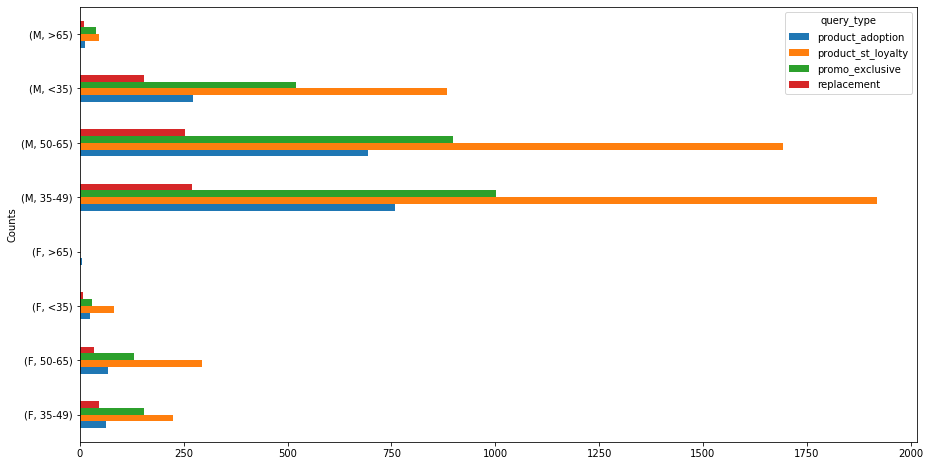

In [75]:
ax = stats_df.groupby(["SEX","AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

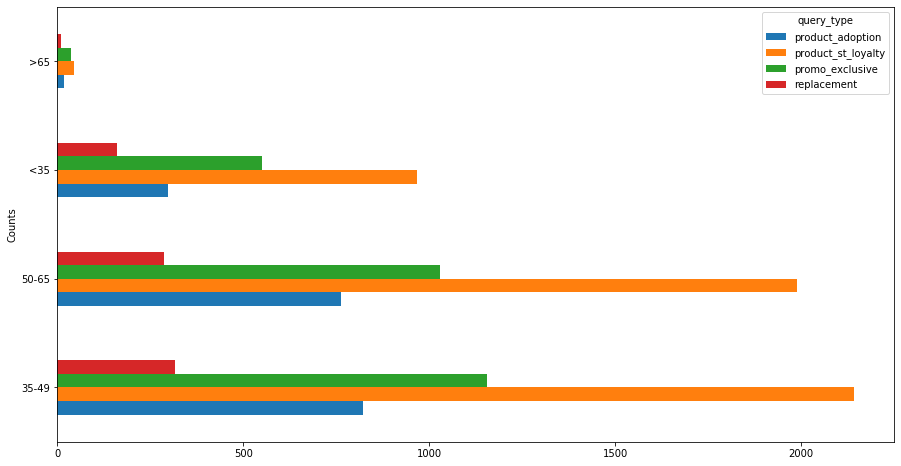

In [76]:
ax = stats_df.groupby(["AGE"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

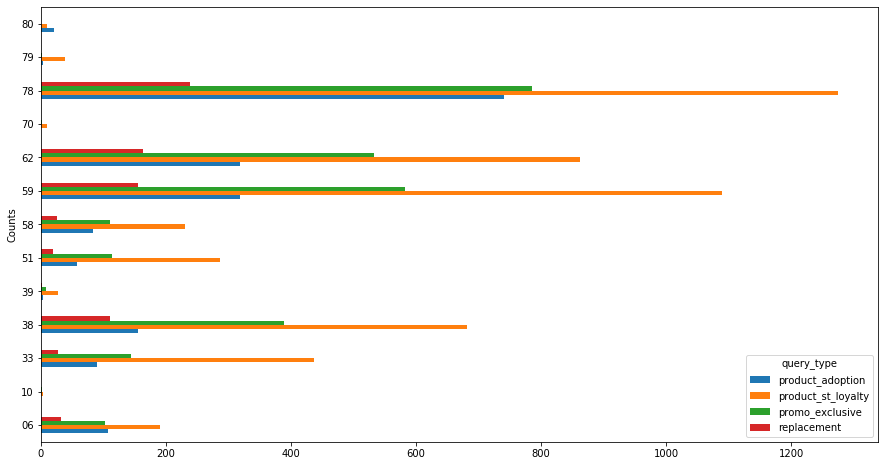

In [77]:
ax = stats_df.groupby(["DEPARTEMENT"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

## By items 

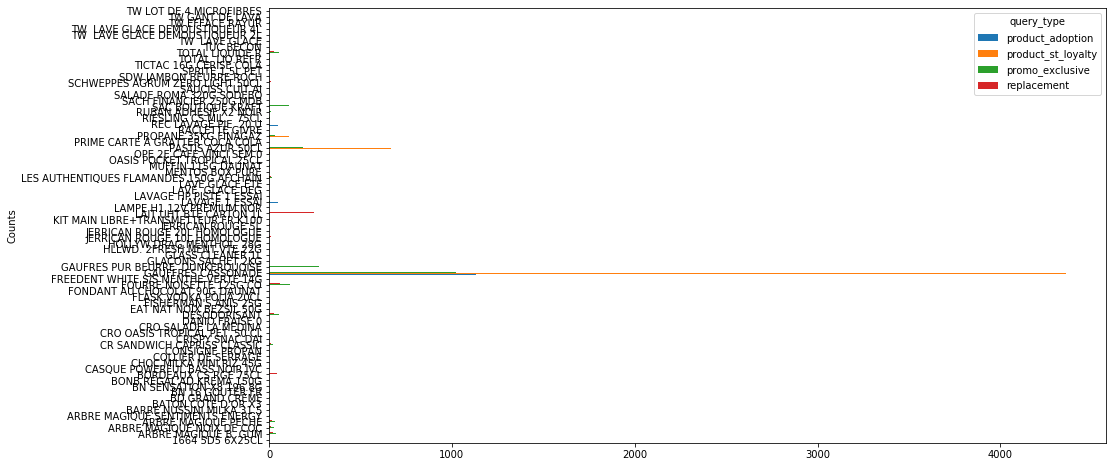

In [78]:
ax = stats_df.groupby(["DESCRIPTION"])["query_type"].value_counts().unstack().plot(kind="barh",figsize=(15,8))
_= ax.set_ylabel("Counts")

In [ ]:
gr